In [41]:
#import libraries needed
import numpy as np
import scipy.sparse.linalg
import pandas as pd
import matplotlib.pyplot as plt

# PCA and LDA comparison

The task for this exercise is to compare PCA and LDA in their ability to cluster when projecting very high-dimensional datapoints to 2 or 3 dimensions. 

In particular, consider the dataset MNIST provided on Virtuale. This dataset contains images of handwritten digits with dimension 28x28, together with a number from 0 to 9 representing the label. 

You are asked to:

#### 1. Load the dataset in memory

In [42]:
data = pd.read_csv('./data.csv')

print(data.head())
print(data.shape)

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         

In [43]:
data = np.array(data)   
print(data.shape)

X0 = data[:, 1:].T
print(X0.shape)

Y0 = data[:, 0]
print(Y0.shape)

(42000, 785)
(784, 42000)
(42000,)


In [44]:
def choose_labels(labels):
    idx = [index for index, elem in enumerate(Y0) if elem in labels]

    X = X0[:, idx]     #take all the rows and just the columns idx
    Y = Y0[idx]

    return X, Y

In [45]:
classes = [0, 6, 9]
X, Y = choose_labels(classes)

print(X.shape, Y.shape)

(784, 12457) (12457,)


In [46]:
def split_data(X, Y, Ntrain):

    d, N = X.shape

    idx = np.arange(N)
    np.random.shuffle(idx)

    train_idx = idx[:Ntrain]
    test_idx = idx[Ntrain:]

    Xtrain = X[:, train_idx]
    Ytrain = Y[train_idx]
    
    Xtest = X[:, test_idx]
    Ytest = Y[test_idx]

    return (Xtrain, Ytrain), (Xtest, Ytest)

In [47]:
Ntrain = 10000

(Xtrain, Ytrain) ,(Xtest, Ytest) = split_data(X,Y,Ntrain)
print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)

(784, 10000) (784, 2457) (10000,) (2457,)


#### 5. Implement the algorithms computing the PCA and LDA of Xtrain with a fixed k. Visualize the results (for k = 2) and the position of the centroid of each cluster.

In [48]:
def get_centroid(X):
    return np.mean(X, axis=1)   

def centroid_of_cluster(Z, Y, label):
    return get_centroid(Z[:, Y==label])

def get_centroids(Z, Y, labels):
    
    centroids = []
    
    for label in labels:
        centroids.append(centroid_of_cluster(Z, Y, label))

    return centroids 

In [49]:
def PCA(X, k):
    centroidX = get_centroid(X)
    r, = centroidX.shape
    centroidX = np.reshape(centroidX, (r, 1))
    X_c = X - centroidX

    U, S, VT = np.linalg.svd(X_c, full_matrices=False) 

    U_k = U[:, :k]
    Z_k = U_k.T @ X_c

    return Z_k, U_k

In [50]:
def LDA(Xtrain, Ytrain, classes, k):
    d, N = Xtrain.shape

    #Find the corresponding indeces
    Xtrain_lda = []
    Ytrain_lda = []
    
    for label in classes:
        index = (Ytrain==label)
        Xtrain_lda += [Xtrain[:, index],]
        Ytrain_lda.append(Ytrain[index])
     
    X = np.concatenate(Xtrain_lda, axis=1)
    Y = np.concatenate(Ytrain_lda)

    # Class centroids
    centroids = []
    for x in Xtrain_lda:
        c = get_centroid(x)
        c = np.reshape(c, (d, 1))
        centroids.append(c)
    
    # Global centroid
    C = get_centroid(X)

    #Within-clusters Scatter Matrix
    X_ci = []
    for i in range(len(Xtrain_lda)):
        X_ci.append(Xtrain_lda[i] - centroids[i])    

    X_w = np.concatenate(X_ci, axis=1)

    S_w = X_w @ X_w.T

    # Between-clusters Scatter Matrix
    Xi_bar = []
    for i in range(len(Xtrain_lda)):
        Xi_bar.append(np.repeat(centroids[i], Xtrain_lda[i].shape[1], axis=1))

    X_bar = np.concatenate(Xi_bar, axis=1)
   
    Xc_bar = X_bar - C.reshape(d,1)
    S_b = Xc_bar @ Xc_bar.T

    try:
        L = np.linalg.cholesky(S_w)
    except:
        eps = 1e-6
        S_w = S_w + eps * np.eye(S_w.shape[0])
        
        L = np.linalg.cholesky(S_w)

    _, W = scipy.sparse.linalg.eigs(np.linalg.inv(L) @ S_b @ L, k) 
    W = np.real(W)
    
    Q = np.linalg.inv(L).T @ W

    Z = Q.T @ X

    return Z, Q


In [51]:
def plot(Z, Y, classes, k, colors, legend):

    clusters = []
    centroids = []
    i = 0

    if(k==3):
        ax = plt.axes(projection="3d")
    
    for label in classes:
        if(k==2):
            fig = plt.scatter(Z[0,Y==label],Z[1,Y==label],marker="o", color=colors[i])
        elif(k==3):
            fig = ax.scatter3D(Z[0,Y==label],Z[1,Y==label],Z[2, Y==label],marker="o", color=colors[i])
        clusters.append(fig)
        i+=1

    plt.legend(legend)

    for label in classes:
        centr = get_centroid(Z[:, Y==label])
        if(k==2):
            plt.scatter(centr[0], centr[1], marker='*', color='red')
        elif(k==3):
            ax.scatter3D(centr[0], centr[1], centr[2], marker='*', color='red')
        centroids.append(centr)

    
    plt.grid()
    plt.legend(legend)

    plt.show()

    return clusters, centroids

PCA


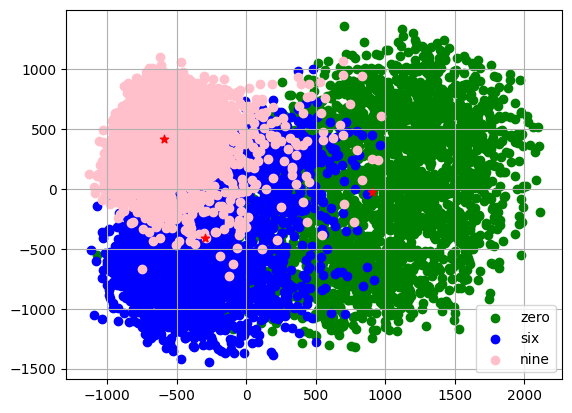

LDA


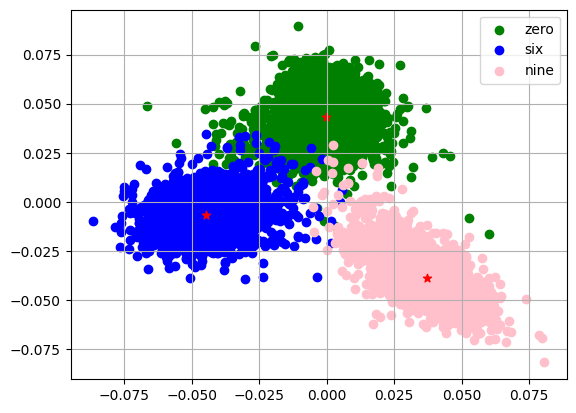

In [52]:
X, Y = choose_labels(classes)
k=2

(Xtrain, Ytrain) ,(Xtest, Ytest) = split_data(X,Y,Ntrain=8000)

#PCA
print("PCA")
Z_pca, proj_PCA = PCA(Xtrain, k)
colors = ['green', 'blue', 'pink']
legend = ["zero","six","nine"]
cluster_pca, centroid_pca = plot(Z_pca, Ytrain, classes, k, colors, legend)

#LDA
print("LDA")
Z_lda, proj_LDA = LDA(Xtrain, Ytrain, classes, k)
Y1 = Ytrain[Ytrain==0]
Y2 = Ytrain[Ytrain==6]
Y3 = Ytrain[Ytrain==9]
Y_lda = np.concatenate((Y1,Y2,Y3))
cluster_lda, centroid_lda = plot(Z_lda, Y_lda, classes, k, colors, legend)

#### For both the algorithms, compute for each cluster the average distance from the centroid.

In [53]:
def distance_from_centroid(clusters, centroids):
    centroid_index = 0
    distances = []

    for cl in clusters:
        points = cl.get_offsets().data
        r, c = points.shape

        dist_point_centr = []

        for i in range(r):
            d = np.linalg.norm(points[i] - centroids[centroid_index], 2)
            dist_point_centr.append(d)

        average = sum(dist_point_centr)/r
        distances.append(average)

        centroid_index += 1
    
    return distances

In [54]:
distances_pca = distance_from_centroid(cluster_pca, centroid_pca)
print(f"[Train] PCA distances: 0 --> {distances_pca[0]}, \t 6--> {distances_pca[1]}, \t 9--> {distances_pca[2]}")

distances_lda = distance_from_centroid(cluster_lda, centroid_lda)
print(f"[Train] LDA distances: 0 --> {distances_lda[0]}, \t 6--> {distances_lda[1]}, \t 9--> {distances_lda[2]}")

[Train] PCA distances: 0 --> 724.9522225178827, 	 6--> 542.6555998945134, 	 9--> 365.5138182025645
[Train] LDA distances: 0 --> 0.013729850834871878, 	 6--> 0.012944993020869294, 	 9--> 0.01296608803587936


#### For both the algorithms, compute for each cluster the average distance from the centroid on the test set.

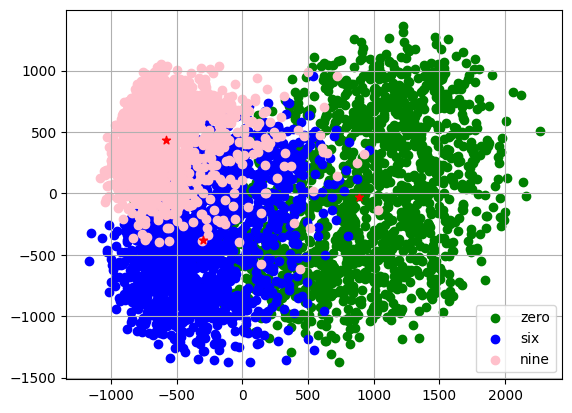

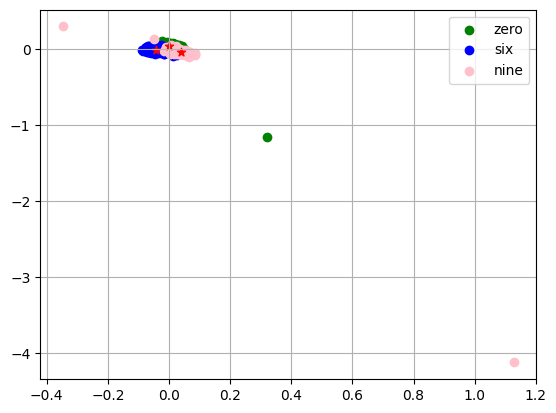

[Test] PCA distances: 0 --> 742.3290425180109, 	 6--> 529.4247258052612, 	 9--> 358.9472458737414
[Test] LDA distances: 0 --> 0.016370990086957127, 	 6--> 0.014179659270199525, 	 9--> 0.017683097726444153


In [55]:
colors = ['green', 'blue', 'pink']
legend = ["zero","six","nine"]

centroidX_test = get_centroid(Xtest)
Z_pca_test =  proj_PCA.T @ (Xtest - np.reshape(centroidX_test, (len(centroidX_test), 1)))
clusters_pca, centroids_pca = plot(Z_pca_test, Ytest, classes, 2, colors, legend)

Z_lda_test = proj_LDA.T @ Xtest
clusters_lda, centroids_lda = plot(Z_lda_test, Ytest, classes, 2, colors, legend)

distances_pca_test = distance_from_centroid(clusters_pca, centroids_pca)
print(f"[Test] PCA distances: 0 --> {distances_pca_test[0]}, \t 6--> {distances_pca_test[1]}, \t 9--> {distances_pca_test[2]}")

distances_lda_test = distance_from_centroid(clusters_lda, centroids_lda)
print(f"[Test] LDA distances: 0 --> {distances_lda_test[0]}, \t 6--> {distances_lda_test[1]}, \t 9--> {distances_lda_test[2]}")

In [56]:
#Average distance from centroid
average_dist_pca_train = sum(distances_pca)/len(distances_pca)
average_dist_lda_train = sum(distances_lda)/len(distances_lda)

average_dist_pca_test = sum(distances_pca_test)/len(distances_pca_test)
average_dist_lda_test = sum(distances_lda_test)/len(distances_lda_test)

print(f"Average distance from centroid PCA train: {average_dist_pca_train}")
print(f"Average distance from centroid LDA train: {average_dist_lda_train}")
print(f"Average distance from centroid PCA test: {average_dist_pca_test}")
print(f"Average distance from centroid LDA test: {average_dist_lda_test}")

Average distance from centroid PCA train: 544.3738802049869
Average distance from centroid LDA train: 0.013213643963873511
Average distance from centroid PCA test: 543.5670047323379
Average distance from centroid LDA test: 0.0160779156945336


#### Define a classification algorithm and compute the accuracy  on the test set for both PCA and LDA.

In [57]:
def classification_algorithm(obs, centroids, gt):
    distance_obs_clusters = []

    for i in range (len(centroids)):
        d = np.linalg.norm(obs - centroids[i], 2)
        distance_obs_clusters.append(d)

    min_index = np.argmin(distance_obs_clusters)

    predicted_class = classes[min_index]

    return predicted_class == gt

def accuracy(X, centroids, Y):
    results = [classification_algorithm(X[:, i], centroids, gt) for i, gt in enumerate(Y)]

    correct_pred = np.sum(results)

    correctness = correct_pred / len(Y)
    print(f'Percentage of correct classifications: {correctness}')
    
    return correctness

In [58]:
classes = [0, 6, 9]

Z_pca_train, proj_PCA = PCA(Xtrain, 2)
centroidX_test = get_centroid(Xtest)
Z_pca_test =  proj_PCA.T @ (Xtest - np.reshape(centroidX_test, (len(centroidX_test), 1)))
centroids_pca = get_centroids(Z_pca_train, Ytrain, classes)

Y_lda_mat = []
for label in classes:
    Y_lda_mat.append(Ytrain[Ytrain==label])

Y_lda = np.concatenate(Y_lda_mat)

Z_lda_train, proj_LDA = LDA(Xtrain, Ytrain, classes, 2)
Z_lda_test = proj_LDA.T @ Xtest
centroids_lda = get_centroids(Z_lda_train, Y_lda, classes)

print('PCA -> Train')
accuracy_pca = accuracy(Z_pca_train, centroids_pca, Ytrain)
print('PCA -> Test')
accuracy_pca = accuracy(Z_pca_test, centroids_pca, Ytest)

print('LDA -> Train')
accuracy_lda = accuracy(Z_lda_train, centroids_lda, Y_lda) 
print('LDA -> Test')
accuracy_lda = accuracy(Z_lda_test, centroids_lda, Ytest) 

PCA -> Train
Percentage of correct classifications: 0.850375
PCA -> Test
Percentage of correct classifications: 0.835315234462643
LDA -> Train
Percentage of correct classifications: 0.989
LDA -> Test
Percentage of correct classifications: 0.9789095804352703


#### Repeat this experiment for different values of k and different digits. 

In [59]:
def try_PCA_LDA(Xtrain, Ytrain, Xtest, Ytest, classes, k):

    print(f"k={k}")

    Zpca_train, new_proj_PCA = PCA(Xtrain, k)
    Zlda_train, new_proj_LDA = LDA(Xtrain, Ytrain, classes, k)

    centroidX_test = get_centroid(Xtest)
    Z_test_pca_new = new_proj_PCA.T @ (Xtest - np.reshape(centroidX_test, (len(centroidX_test), 1)))

    Z_test_lda_new = new_proj_LDA.T @ Xtest

    Y_lda_mat = []
    for label in classes:
        Y_lda_mat.append(Ytrain[Ytrain==label])
    Y_lda = np.concatenate(Y_lda_mat)

    centroids_pca_new = get_centroids(Zpca_train, Ytrain, classes)
    centroids_lda_new = get_centroids(Zlda_train, Y_lda, classes)
   
    print('PCA')
    pca_acc = accuracy(Z_test_pca_new, centroids_pca_new, Ytest)

    print('LDA')
    lda_acc = accuracy(Z_test_lda_new, centroids_lda_new, Ytest)

    return (pca_acc, lda_acc)

k=2
PCA
Percentage of correct classifications: 0.841091492776886
LDA
Percentage of correct classifications: 0.9828785446762975
k=22
PCA
Percentage of correct classifications: 0.9577314071696095
LDA
Percentage of correct classifications: 0.9823434991974318
k=42
PCA
Percentage of correct classifications: 0.9579989299090422
LDA
Percentage of correct classifications: 0.9826110219368647
k=62
PCA
Percentage of correct classifications: 0.9582664526484751
LDA
Percentage of correct classifications: 0.9823434991974318
k=82
PCA
Percentage of correct classifications: 0.9582664526484751
LDA
Percentage of correct classifications: 0.9828785446762975


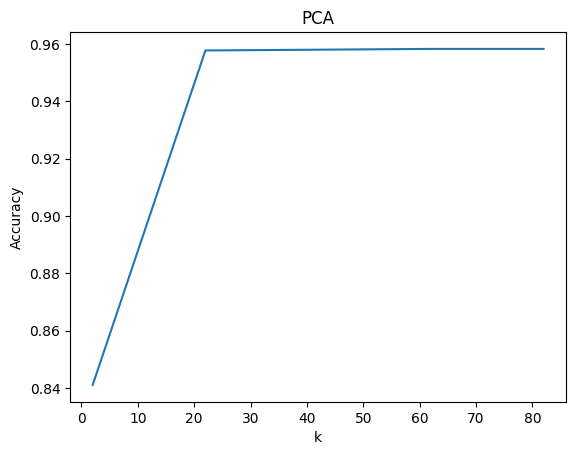

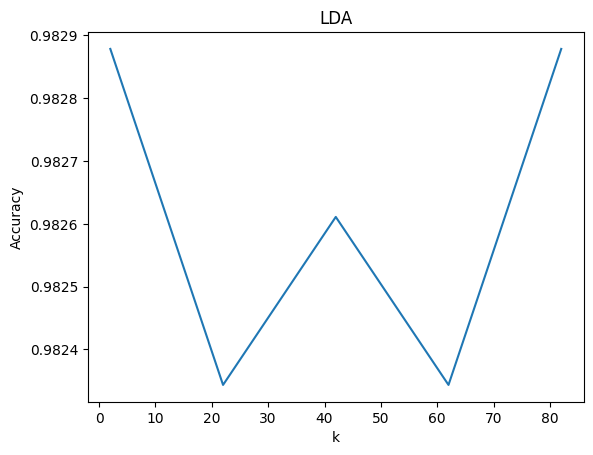

In [60]:
classes = [0, 6, 9]

X, Y = choose_labels(classes)
_, N = X.shape
Ntrain = int(0.7*N)
(Xtrain, Ytrain), (Xtest, Ytest) = split_data(X, Y, Ntrain)

k_test = np.arange(2, 100, 20)
pca = []
lda = []

for k in k_test:
    pca_acc, lda_acc = try_PCA_LDA(Xtrain, Ytrain, Xtest, Ytest, classes, k)
    pca.append(pca_acc)
    lda.append(lda_acc)

plt.plot(k_test, pca)
plt.title('PCA')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()

plt.plot(k_test, lda)
plt.title('LDA')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()

# Visulizing dyad

In [61]:
#import libraries needed
import numpy as np
import matplotlib.pyplot as plt
import skimage.data as skd

### Consider an image from skimage.data. For simplicity, say that X $\in R^{mn}$ is the matrix representing that image. You are asked to visualize the dyad of the SVD Decomposition of X and the result of compressing the image via SVD. 

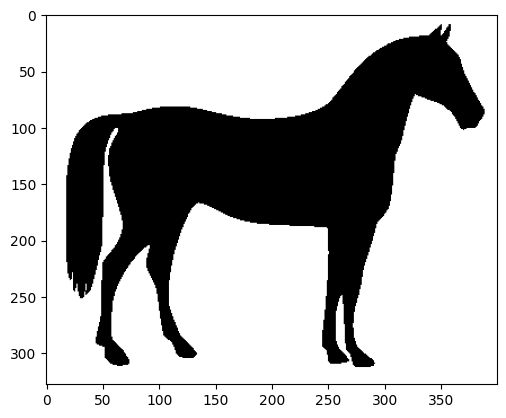

u.shape:(328, 328), s.shape:(328,), v.shape:(400, 400)


In [62]:
img = skd.horse() 
plt.imshow(img, cmap = 'gray')
plt.show()

U, S, VT = np.linalg.svd(img)

print(f'u.shape:{U.shape}, s.shape:{S.shape}, v.shape:{VT.shape}')

#### Visualize some of the dyad of this decomposition.

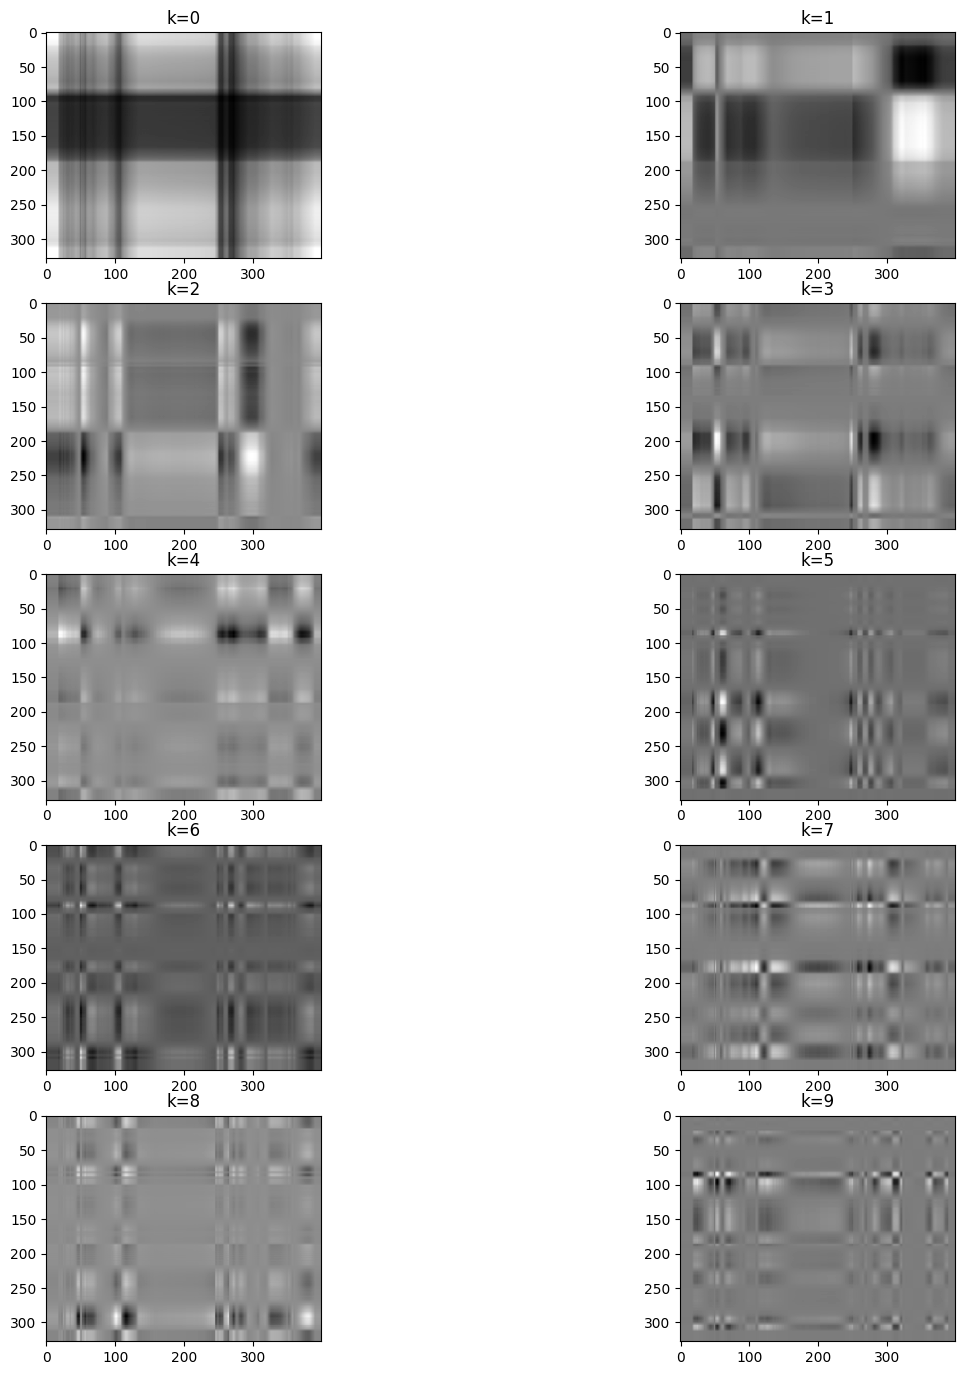

In [63]:
def calculate_dyad(U, VT, i):
    U_i = U[:, i].reshape(len(U[0]), 1)
    VT_i = VT[i, :].reshape(1, len(VT[0]))
    A_i = U_i @ VT_i 

    return A_i

plt.figure(figsize=(15, 17))
for k in range(10):
    A_i = calculate_dyad(U, VT, k)
    plt.subplot(5, 2, k+1)
    plt.title(f"k={k}")
    plt.imshow(A_i, cmap='gray')
plt.show()

#### Plot the singular values of X. 

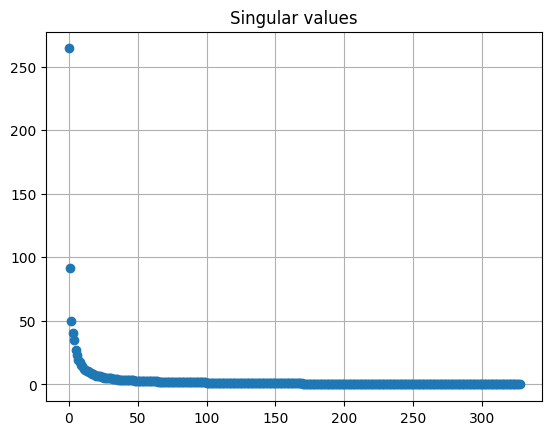

In [64]:
plt.plot(S, 'o')
plt.title('Singular values')
plt.grid()
plt.show()

#### Visualize the k-rank approximation of X for different values of k.

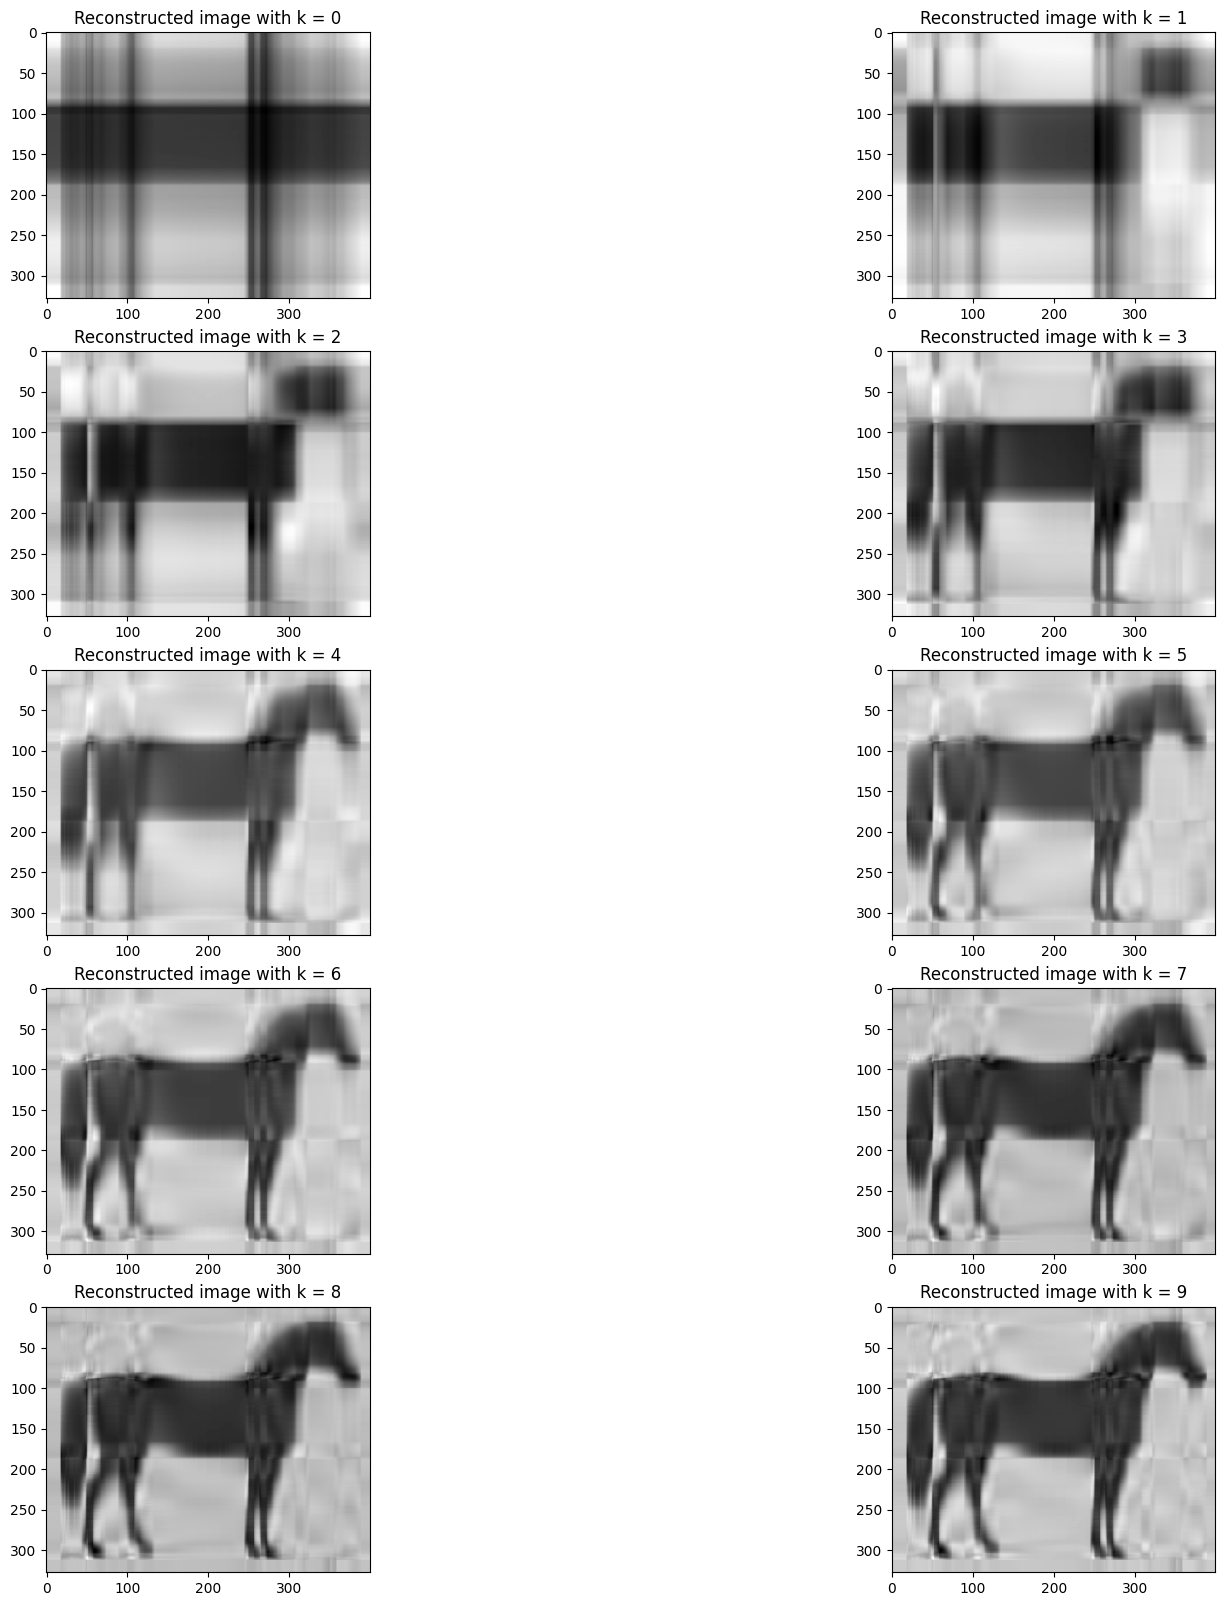

In [65]:
def calculate_appr(A_prev, U, S, VT, k):
    A_i = calculate_dyad(U, VT, k)
    S_i = S[k]    
    A_k = A_prev + A_i*S_i

    return A_k

A_k = np.zeros(img.shape)

plt.figure(figsize=(20, 20))
for k in range (10):
    A_k = calculate_appr(A_k, U, S, VT, k)
    plt.subplot(5, 2, k+1)
    plt.title(f"Reconstructed image with k = {k}")
    plt.imshow(A_k, cmap='gray')
plt.show()

#### Compute and plot the approximation error and the compression factor $\frac {k}{mn}$ for increasing values of k.

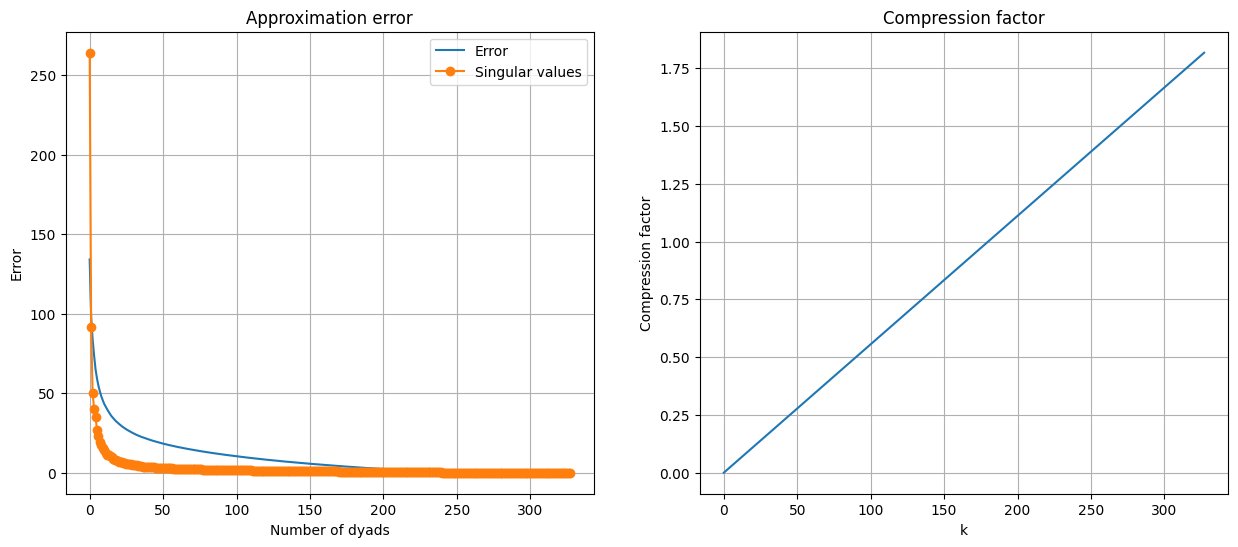

In [68]:
def approximation_error(A, A_k):
    error = np.linalg.norm(A - A_k)
    return error

def calculate_compresssion_factor(k, m, n):
    return (k*(1+m+n))/(m*n)

A_k = np.zeros(img.shape)
m, n = img.shape
k = np.arange(0, len(S))

error = []
compression_factor = []

for i in k:
    A_k = calculate_appr(A_k, U, S, VT, i)
    error.append(approximation_error(img, A_k))

    c_f = calculate_compresssion_factor(i, m, n)
    compression_factor.append(c_f)

plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
plt.plot(k, error)
plt.plot(k, S, '-o')
plt.legend(['Error', 'Singular values'])
plt.title("Approximation error")
plt.xlabel('Number of dyads')
plt.ylabel('Error')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(k, compression_factor)
plt.title("Compression factor")
plt.xlabel('k')
plt.ylabel('Compression factor')
plt.grid()

plt.show()